In [1]:
import cv2
import torch
from torch import optim
from torch.autograd.functional import jacobian
from PIL import Image
import OpenEXR, Imath
import numpy as np
from matplotlib import pyplot as plt
import time
import skfmm
from scipy.optimize import minimize, Bounds
from autograd import grad, jacobian
from jax import jacfwd, jacrev, grad
import jax.numpy as jnp

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['JAX_DEBUG_NANS'] = '1'

In [3]:
from jax.config import config
config.update("jax_debug_nans", True)

In [4]:
def exr_to_np(path):
    y_resolution = 540
    x_resolution = 810
    pt = Imath.PixelType(Imath.PixelType.FLOAT)
    
    rgb_exr = OpenEXR.InputFile(path)
    rgb_dw = rgb_exr.header()['dataWindow']
    rgb_size = (rgb_dw.max.x - rgb_dw.min.x + 1, rgb_dw.max.y - rgb_dw.min.y + 1)
    r_str = rgb_exr.channel('R', pt)
    g_str = rgb_exr.channel('G', pt)
    b_str = rgb_exr.channel('B', pt)
    rgb_img = np.zeros((y_resolution, x_resolution, 3))
    r_ch = Image.frombytes("F", rgb_size, r_str)
    g_ch = Image.frombytes("F", rgb_size, g_str)
    b_ch = Image.frombytes("F", rgb_size, b_str)
    rgb_img[: ,:, 2] = np.array(r_ch.getdata()).reshape(y_resolution, x_resolution)
    rgb_img[: ,:, 1] = np.array(g_ch.getdata()).reshape(y_resolution, x_resolution)
    rgb_img[: ,:, 0] = np.array(b_ch.getdata()).reshape(y_resolution, x_resolution)
    min_val = rgb_img.min()
    max_val = rgb_img.max() 
    rgb_img = ((rgb_img - min_val)/(max_val - min_val) * 255.0).astype(np.uint8)
    return rgb_img

In [5]:
def depth_exr_to_np(path):
    y_resolution = 540
    x_resolution = 810
    pt = Imath.PixelType(Imath.PixelType.FLOAT)
    
    depth_exr = OpenEXR.InputFile(path)
    depth_dw = depth_exr.header()['dataWindow']
    depth_size = (depth_dw.max.x - depth_dw.min.x + 1, depth_dw.max.y - depth_dw.min.y + 1)
    depth_str = depth_exr.channel('R', pt)
    depth = Image.frombytes("F", depth_size, depth_str)
    depth_img = np.array(depth.getdata()).reshape(y_resolution, x_resolution)
    depth_img = depth_img * 1000.0
    return depth_img

In [6]:
def threshold(img, v_min, v_max):
    '''
    threshold an img using v_min and v_max; img.shape[2] = v_min.shape[0] = v_max.shape[0]
    '''
    H, W, C = img.shape
    mask =  np.ones((H, W))
    for i in range(C):
        mask_i_1 = img[:, :, i] > v_min[i]
        mask_i_2 = img[:, :, i] < v_max[i]
        mask_i = np.logical_and(mask_i_1, mask_i_2)
        mask = np.logical_and(mask, mask_i)
    return mask

In [7]:
def sign_nozero(p):
    '''
    Similar to np.sign but output is 1 if value is zero
    '''
    p = p.astype(float)
    s = np.sign(p)
    s[s == 0] = 1
    return s

In [8]:
def dist_to_line_2d(xy, c1, c2):
    '''
    Input:
        xy: (2, Nm) jax numpy array - xy(h, w) is the coordinate
        c1: (2,) jax numpy array - (x,y) of one end
        c2: (2,) jax numpy array - (x,y) of another end
    '''
    xy_c1 = xy - c1.reshape(2,1)
    c12 = (c2 - c1).reshape(2,1)
    c12_length = jnp.linalg.norm(c12)
    c12 = c12/c12_length
    closest_dist = jnp.clip(jnp.sum(xy_c1 * c12, axis=0), 0, c12_length)
    closest_pt = c1.reshape(2,1) + closest_dist * c12
#     dist = jnp.linalg.norm(xy - closest_pt+1e-10, axis = 0)
    dist = jnp.sum(jnp.square(xy - closest_pt), axis = 0)
    # otherwise derivative at 0 is undefined
    return dist

In [9]:
class indi_pt_tracker:
    def __init__(self, H, W, l, debug=False, reg=False, ratio=1.0):
        self.H = H
        self.W = W
        self.l = l
        self.lam = 20.
        self.debug = debug
        self.reg = reg
        self.ratio = ratio
        self.model_jac_fn_jax = jacfwd(self.model_obj_fn)
        
    def set_obs(self, mask, rgb_np=None, depth_np=None, subsample=False):
        if subsample:
            import point_cloud_utils as pcu

            # v is a nv by 3 NumPy array of vertices
            # n is a nv by 3 NumPy array of vertex normals
            # n is a nv by 4 NumPy array of vertex colors
            N = np.array(mask.nonzero()).shape[1]
            v = np.zeros((N, 3))
            n = np.zeros_like(v)
            c = np.zeros((N, 4))
            v[:, :2] = np.array(mask.nonzero()).T
            n[:, 2] = 1.

            # We'll use a voxel grid with 128 voxels per axis
            num_voxels_per_axis = 128

            # Size of the axis aligned bounding box of the point cloud
            bbox_size = v.max(0) - v.min(0) + np.array([0., 0., 0.1])

            # The size per-axis of a single voxel
            sizeof_voxel = bbox_size / num_voxels_per_axis

            # Downsample a point cloud on a voxel grid so there is at most one point per voxel.
            # Multiple points, normals, and colors within a voxel cell are averaged together.
            v_sampled, n_sampled, c_sampled = pcu.downsample_point_cloud_voxel_grid(sizeof_voxel, v, n, c)
            mask_idx_spl = v_sampled[:, :2].astype(int)
            mask_spl = np.zeros_like(mask)
            mask_spl[mask_idx_spl[:, 0], mask_idx_spl[:, 1]] = True
            self.mask = mask_spl
            
        # occlusion weight map
        if depth_np is not None:
            occl_map = depth_np < 2000.0
            occl_dist = skfmm.distance(~occl_map, dx = 1)
            sigma = 60.
#                 self.occl_w_map = 1-np.exp(-occl_dist/sigma)
            self.occl_w_map = np.zeros_like(occl_dist)
            self.occl_w_map[occl_dist<=sigma] = -1.0
            self.occl_w_map[occl_dist>sigma] = 1.0
        else:
            self.occl_w_map = np.ones_like(mask).astype(float)
        
        mask = (~mask).astype(np.uint8)
        phi = np.where(mask, 0, -1) + 0.5
        dist = skfmm.distance(phi, dx = 1)
        dist = dist - dist.min() # - 1
        sobelx = cv2.Sobel(dist,cv2.CV_64F,1,0,ksize=-1)/30.56
        sobely = cv2.Sobel(dist,cv2.CV_64F,0,1,ksize=-1)/30.56

        self.full_mask = mask
        self.dist = dist
        self.dist_x = sobelx
        self.dist_y = sobely
                
        self.rgb_np = rgb_np
        self.depth_np = depth_np
    
    def find_nonmask(self, p):
        '''
        Input: p: jax numpy array (Np, 2)
        '''
        nonmask_idx = jnp.array(self.full_mask.nonzero())
        Np = p.shape[0]
        dist_all = jnp.zeros((Np-1,nonmask_idx.shape[1]))
        for i in range(Np-1):
            dist_all = dist_all.at[i].set(dist_to_line_2d(nonmask_idx, p[i], p[i+1]))
        dist = dist_all.min(axis=0)
        nonmask_idx = nonmask_idx[:, dist < 10]
        return nonmask_idx
    
    def p2ang(self, p):
        '''
        Input: p: numpy array (Np, 2)
        Output: ang: numpy array (Ne)
        '''
        p = p.astype(float)
        dx = p[1:, 1] - p[:-1, 1]
        dy = p[1:, 0] - p[:-1, 0]
        ang_0_pi = np.arccos(dx/np.sqrt(np.square(dx)+np.square(dy)))
        dy[ang_0_pi==0] += 0.01 # singular value for ang_0_pi = 0 or anf_0_pi = pi
        ang = np.sign(dy)*ang_0_pi
        return ang
    
    def hard_constrain(self, p):
        '''
        p: numpy array (Np,2)
        '''
        p = np.maximum(p, np.zeros_like(p))
        p[:,0] = np.minimum(p[:,0], np.ones(p[:,0].shape, dtype=int)*(self.H-1))
        p[:,1] = np.minimum(p[:,1], np.ones(p[:,1].shape, dtype=int)*(self.W-1))
        return p
    
    def set_init(self, p):
        '''
        p: numpy array (Np,2)
        '''
        self.p = p
        self.ang = self.p2ang(self.p)
        lb = np.zeros(p.shape[0]*2)
        ub = np.ones(p.shape[0]*2)
        ub[0::2] = self.H-1
        ub[1::2] = self.W-1
        self.bound = Bounds(lb, ub)
    
    '''
    OBJECTIVE FUNCTION DEFINITION
    '''
    
    def obj_fn(self, p):
        '''
        Input: p: numpy array, (2*Np,)
        '''
#         ratio = np.array(self.mask.nonzero()).shape[1]/(5.0*p.shape[0])
        ratio = self.ratio
        l_obs = self.obs_obj_fn(p)
        p = jnp.array(p.reshape(-1, 2))
        l_model = self.model_obj_fn(p)
        loss = l_obs+ratio*l_model
        if self.debug:
            print('---- In Obj Fn ----')
            print('p:')
            self.vis(p=np.array(p).astype(int))
            print('l_obs:')
            print(l_obs)
            print('l_model:')
            print(l_model)
            print('loss')
            print(loss)
            print('---- End of Obj Fn ----')
        return loss
    
    def obs_obj_fn(self, p):
        '''
        p: numpy array (2*Np,)
        '''
        loss = 0
        p = p.reshape(-1,2)
        if self.reg:
#             d_ang = self.p2ang(p) - self.ang
#             loss += np.sum(self.lam*np.abs(d_ang))
            ang = self.p2ang(p)
            loss += 0.5*self.lam*np.sum(np.square(ang[:-1]-ang[1:]))
        p = p.astype(int)
        p = self.hard_constrain(p)
        loss += 0.5*np.sum(np.square(self.occl_w_obs[:,None]*self.dist[p[:,0], p[:,1]]))
#         loss += np.sum(self.occl_w_obs[:,None]*self.dist[p[:,0], p[:,1]])
        
        if self.debug:
            print('loss of distance:')
            print(0.5*np.sum(np.square(self.occl_w_obs[:,None]*self.dist[p[:,0], p[:,1]])))
            if self.reg:
                print('ang:')
                print(ang)
                print('loss of angle:')
                print(0.5*self.lam*np.sum(np.square(ang[:-1]-ang[1:])))
#             print('loss value:')
#             print(loss)
        return loss
    
    def model_obj_fn(self, p):
        '''
        Input: p: jax numpy array, (Np,2)
        '''
        mask_idx = jnp.array(self.mask.nonzero())
#         nonmask_idx = self.find_nonmask(p)
        Np = p.shape[0]
        dist_mask = jnp.zeros((Np-1,mask_idx.shape[1]))
#         dist_nonmask = jnp.zeros((Np-1,nonmask_idx.shape[1]))
#         prev_dist = dist_to_line_2d(mask_idx, p[0], p[1])
        for i in range(Np-1):
            # TODO: add occlusion weight here
#             dist_all = dist_all.at[i].set(dist_to_line_2d(mask_idx, p[i], p[i+1])/(self.occl_w[i]+0.01))
            dist_mask = dist_mask.at[i].set(dist_to_line_2d(mask_idx, p[i], p[i+1]))
#             if self.occl_w_obs[i] < 0.5:
#                 dist_mask_to_pi = float('Inf')*jnp.ones(mask_idx.shape[1])
#             else:
#                 dist_mask_to_pi = jnp.linalg.norm(mask_idx-p[i][:, None]+1e-10, axis=0)/(self.occl_w_obs[i]+1e-10)
#             dist_mask = dist_mask.at[i].set(dist_mask_to_pi)
#             print(jnp.linalg.norm(mask_idx-p[i]+1e-10, axis=0).shape)
#             print(mask_idx.shape)
#             print(p[i].shape)
#             dist_nonmask = dist_nonmask.at[i].set(dist_to_line_2d(nonmask_idx, p[i], p[i+1]))
#             dist = jnp.minimum(dist_to_line_2d(mask_idx, p[i], p[i+1]), prev_dist)
#             prev_dist = dist
#         weight_seg_idx = (dist_mask/(self.occl_w_obs+1e-10)[:, None]).argmin(axis=0)
#         seg_idx = dist_mask.argmin(axis=0)
#         print(jnp.abs(weight_seg_idx-seg_idx).sum())
#         weight_dist = dist_mask[seg_idx, np.arange(mask_idx.shape[1])]
        dist = dist_mask.min(axis=0)
#         print(jnp.abs(weight_dist-dist).sum())
#         nondist = dist_nonmask.min(axis=0)
#         occl_w = jnp.array(self.occl_w)
#         dist = dist*occl_w[seg_idx]
        return dist.sum()#-nondist.sum()
    
    '''
    JACOBIAN FUNCTION DEFINITION
    '''
    
    def jac_fn(self, p):
        '''
        Input: p: numpy array, (2*Np,)
        '''
#         ratio = np.array(self.mask.nonzero()).shape[1]/(5.0*p.shape[0])
        ratio = self.ratio
        J_obs = self.obs_jac_fn(p)
        p = jnp.array(p.reshape(-1, 2))
        J_model = np.array(self.model_jac_fn_jax(p)).reshape(-1)
        J = J_obs + ratio*J_model
        if self.debug:
            print('---- In Jac Fn ----')
            print('p:')
            self.vis(p=np.array(p).astype(int))
            print('J:')
            print(J)
            print('J_obs:')
            print(J_obs)
            print('J_model:')
            print(J_model)
            print('---- End of Jac Fn ----')
        return J
    
    
    def obs_jac_fn(self, p):
        '''
        p: numpy array (2*Np,)
        '''
        p = p.reshape(-1,2)
        
        # Jacobian for the angle change
        J_ang = np.zeros(p.shape)
        if self.reg:
            dx = p[1:, 1] - p[:-1, 1]
            dy = p[1:, 0] - p[:-1, 0]
            l = np.square(dx)+np.square(dy)
#             d_ang = self.p2ang(p) - self.ang
#             J_ang[1:, 0] += self.lam*np.sign(d_ang)*dx/l
#             J_ang[1:, 1] += -self.lam*np.sign(d_ang)*dy/l
#             J_ang[:-1,0] += -self.lam*np.sign(d_ang)*dx/l
#             J_ang[:-1,1] += self.lam*np.sign(d_ang)*dy/l
            ang = self.p2ang(p)
            d_ang = ang[:-1] - ang[1:]
            J_ang[0:-2, 0] += self.lam*d_ang*dx[0:-1]/l[0:-1]
            J_ang[0:-2, 1] += -self.lam*d_ang*dy[0:-1]/l[0:-1]
            J_ang[1:-1, 0] += -self.lam*d_ang*(dx[0:-1]/l[0:-1]+dx[1:]/l[1:])
            J_ang[1:-1, 1] += self.lam*d_ang*(dy[0:-1]/l[0:-1]+dy[1:]/l[1:])
            J_ang[2:, 0] += self.lam*d_ang*dx[1:]/l[1:]
            J_ang[2:, 1] += -self.lam*d_ang*dy[1:]/l[1:]
            
        p = p.astype(int)
        p = self.hard_constrain(p)
        # Jacobian for distance residuals
        J_D = np.zeros(p.shape)
        J_D[:, 1] = self.occl_w_obs*self.dist_x[p[:, 0], p[:, 1]]
        J_D[:, 0] = self.occl_w_obs*self.dist_y[p[:, 0], p[:, 1]]
        J_D = (self.dist[p[:, 0], p[:, 1]]*self.occl_w_obs)[:,None]*J_D
        
#         if self.debug:
#             print('Distance Jacobian:')
#             print(J_D)
#             print('Angle Jacobian:')
#             print(J_ang)
        return ((J_D+J_ang).reshape(-1))
    
    '''
    TRANSLATION TEST [ABANDONED]
    '''
    
    def trans_obj_fn(self, xy, p):
        '''
        xy: numpy array (2,)
        p: numpy array (Np,2)
        '''
        p = p + xy
        p = p.astype(int)
        J = np.zeros_like(xy)
        loss = 0.5*np.sum(np.square(self.dist[p[:,0], p[:,1]]))
        return loss
    
    def trans_jac_fn(self, xy, p):
        '''
        xy: numpy array (2,)
        p: numpy array (Np,2)
        '''
        p = p + xy
        p = p.astype(int)
        J_D = np.zeros(p.shape)
        J_D[:, 1] = self.dist_x[p[:, 0], p[:, 1]]
        J_D[:, 0] = self.dist_y[p[:, 0], p[:, 1]]
        J_D = self.dist[p[:, 0], p[:, 1]][:, None]*J_D
        J = J_D.sum(axis = 0)
        return J
    
    '''
    CONSTRAINTS
    '''
    
    def fixed_len(self, p):
        '''
        p: numpy array (2*Np,)
        '''
        p = p.reshape(-1,2)
        return np.sum(np.abs(np.linalg.norm(p[1:] - p[:-1], axis=1) - self.l))
    
    def fixed_len_i(self, p, i):
        p = p.reshape(-1,2)
        return np.linalg.norm(p[i]-p[i+1])-self.l
    
    def fixed_len_jac(self, p):
        '''
        p: numpy array (2*Np,)
        '''
        p = p.reshape(-1,2)
        dp = p[1:] - p[:-1]
        dp_norm = np.linalg.norm(dp, axis=1)
        
        J = np.zeros_like(p)
        J[:-1, 0] += np.sign(dp_norm-self.l)*(p[:-1,0]-p[1:,0])/dp_norm
        J[:-1, 1] += np.sign(dp_norm-self.l)*(p[:-1,1]-p[1:,1])/dp_norm
        J[1:, 0] += np.sign(dp_norm-self.l)*(p[1:,0]-p[:-1,0])/dp_norm
        J[1:, 1] += np.sign(dp_norm-self.l)*(p[1:,1]-p[:-1,1])/dp_norm
        if (J==0).all():
            J[:,:] = 1e-6
        if self.debug:
            print('In constrain jac')
            print(J)
#         J = np.sign(dp_norm-self.l)[:, None] * J
        return J.reshape(-1)

    def fixed_len_i_jac(self, p, i):
        p = p.reshape(-1,2)
        J = np.zeros_like(p)
        norm = np.linalg.norm(p[i]-p[i+1])
        J[i, 0] = (p[i, 0]-p[i+1, 0])/norm
        J[i, 1] = (p[i, 1]-p[i+1, 1])/norm
        J[i+1, 0] = (p[i+1, 0]-p[i, 0])/norm
        J[i+1, 1] = (p[i+1, 1]-p[i, 1])/norm
        return J.reshape(-1)
    
    '''
    STEP FUNCTION
    '''
    
    def trans_step(self):
        p = self.p.copy()
        xy = np.zeros(2)
        res = minimize(self.trans_obj_fn, xy, jac=self.trans_jac_fn, method='BFGS', args=(p))
        self.p = p + res.x
    
    def step(self, debug=False):
        self.debug = debug
        p = self.p.copy().reshape(-1)
        cons = []
        fixed_len = {
            'type': 'eq',
            'fun': self.fixed_len,
            'jac': self.fixed_len_jac
        }
        opt = {
            'maxiter': 5000,
            'disp': True,
            'ftol': 1.0
        }
        for i in range(p.shape[0]//2-1):
            fixed_len_i = {
                'type': 'eq',
                'fun': self.fixed_len_i,
                'jac': self.fixed_len_i_jac,
                'args': [i]
            }
            cons.append(fixed_len_i)
        p_mean = (0.5*(self.p[:-1] + self.p[1:])).astype(int)
        self.occl_w = self.occl_w_map[p_mean[:, 0], p_mean[:, 1]]
        self.occl_w_obs = self.occl_w_map[self.p[:, 0].astype(int), self.p[:, 1].astype(int)]
        print("model-based occlusion weight:")
        print(self.occl_w)
        print("observation-based occlusion weight:")
        print(self.occl_w_obs)
        res = minimize(self.obj_fn, p, jac=self.jac_fn, constraints=cons, method='SLSQP', bounds=self.bound, options=opt, tol=1.0)
        print(res)
        self.p = res.x.reshape(-1, 2)
        self.ang = self.p2ang(self.p)
        
    def vis(self, save_dir=None, idx=0, p=None):
        if self.rgb_np is not None:
            vis_img = self.rgb_np.copy()
        else:
            vis_img = np.zeros((self.H, self.W))

        radius = 5
        color = (255, 0, 0)
        thickness = 3
        
        if p is None:
            for i in range(self.p.shape[0]):
                vis_img = cv2.circle(vis_img, (int(self.p[i][1]), int(self.p[i][0])), radius, color, thickness)
        else:
            for i in range(p.shape[0]):
                vis_img = cv2.circle(vis_img, (int(p[i][1]), int(p[i][0])), radius, color, thickness)
        plt.imshow(vis_img)
        if save_dir is not None:
            import pathlib
            pathlib.Path(save_dir).mkdir(parents=True, exist_ok=True)
            plt.savefig(save_dir+"frame_"+'{0:03d}'.format(idx)+".png", dpi=300)
        plt.show()

model-based occlusion weight:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
observation-based occlusion weight:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 490.8747
            Iterations: 8
            Function evaluations: 22
            Gradient evaluations: 8
     fun: DeviceArray(490.8747, dtype=float32)
     jac: array([ 2.78420634e+00, -2.67565002e+00, -4.69655573e+00, -4.37596623e-01,
        1.33023838e+00,  7.31895580e-01,  7.06334669e-01,  2.72920442e-01,
        2.32304247e-01,  5.07167766e-02,  3.04117838e-01,  1.63516653e-02,
       -5.71306205e-02, -1.92207782e-04, -1.81073957e-03, -6.57544606e-07,
       -1.26289847e-03,  1.84081081e-07,  5.56620292e-04,  3.72118380e-08,
       -9.78457185e-05,  1.34955536e-09])
 message: 'Optimization terminated successfully'
    nfev: 22
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([206.95118065, 199.56512814, 195.86575977, 216.31414936,
       20

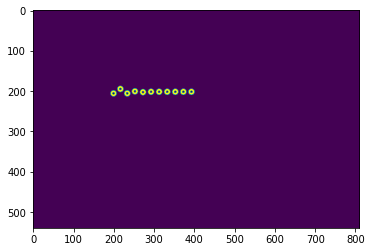

In [11]:
# sanity check for LSLQP
H = 540
W = 810
l = 20
simple_tracker = indi_pt_tracker(H, W, l, debug=True, reg=True, ratio=0.0)
q = np.zeros((11,2))
q[:, 0] = 10
q[:, 1] = np.arange(180, 381, 20)
simple_tracker.set_init(q)
mask = np.zeros((H, W), dtype=bool)
mask[200:205, 200:400] = True
simple_tracker.set_obs(mask, subsample=True)
# simple_tracker.trans_step()
simple_tracker.step(debug=False)
simple_tracker.vis()